## Reading in packages

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap
import matplotlib as mpl
import scanpy as sc

## Read in data

Select either the whole sc transformed dataset or just the variable genes

In [113]:
ILC_var = sc.read("sct_variable.h5ad")
ILC = sc.read("sct.h5ad")

c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [114]:
PCA_coord = ILC_var.obsm["X_pca"]
Diff_coord = ILC_var.obsm["X_diffmap"]

In [115]:
#norm_reads_sparse = ILC_var.layers["norm_data"]
norm_reads_sparse = ILC.layers["norm_data"]
norm_reads = pd.DataFrame(norm_reads_sparse.toarray())
print("Norm reads: "+repr(norm_reads.shape))

UMAP = ILC_var.obsm["umap_cell_embeddings"]
Diff = ILC_var.obsm['X_draw_graph_fa']

Norm reads: (26877, 15806)


## Selecting all ILC2 and ILC3 cells

### Run if writing csv files

In [116]:
Variable = ILC_var.var

Obs = ILC_var.obs
O = Obs["ilc2_ilc3"].to_frame()

Variable["Selected"].to_csv('Gene_list_ILC.csv', sep=',')
O.to_csv('Cell_list_ILC.csv', sep=',')

### Run if reading csv files

In [117]:
Gene_list = pd.read_csv("Gene_list_ILC.csv", sep=",", header = 0)
Gene_list = np.array(Gene_list)
Gene_list = Gene_list[:,0]
Cell_list = pd.read_csv("Cell_list_ILC.csv", sep=",", header = 0)
Cell_list = np.array(Cell_list)
Cell_list = Cell_list[:,0]

print("Gene list:"+repr(Gene_list))
print("Cell list:"+repr(Cell_list))

Gene list:array(['Yfp', 'Rb1cc1', 'Mcmdc2', ..., 'mt-Cytb', 'AC149090.1',
       'Cre (Il5)'], dtype=object)
Cell list:array(['Timept0.AAACCCAAGCTATCTG', 'Timept0.AAACCCAAGGTAATCA',
       'Timept0.AAACCCAAGTCTAACC', ..., 'Timept4.TTTGTTGCATCCAATG',
       'Timept4.TTTGTTGTCATTCATC', 'Timept4.TTTGTTGTCGCACTCT'],
      dtype=object)


## Collecting cells of interest

In this model of psoriasis, tissue resident ILC2s are reprogramed to ILC3s. 

For analysis we are selecting for cells likely to be ILC2s or ILC3s on the basis of previously characterized populations.

In [118]:
#We have four labeled groups of cells that we want to collect together
ILC2_ILC3 = ILC_var.obs["ilc2_ilc3"]
ILC3_Q = ILC_var.obs["quiescent_ilc3"]
ILC2_Q = ILC_var.obs["ilc2_quiescent"]
cloud_ILC3 = ILC_var.obs["cloud_ilc3"]

df = pd.DataFrame(dict(ILC2_ILC3 = ILC2_ILC3, ILC3_Q = ILC3_Q, ILC2_Q = ILC2_Q, cloud_ILC3 = cloud_ILC3))
cells = df.shape[0]

In [119]:
#binary yes ir no for if the cell is in our group
in_transition = np.zeros((cells, 1))

#Value of group - 0 if NA - over all cells
allcell_ILC2_ILC3 = np.zeros((cells, 1))
allcell_ILC3_Q = np.zeros((cells, 1))
allcell_ILC2_Q = np.zeros((cells, 1))
allcell_cloud_ILC3 = np.zeros((cells, 1))

#Cell labels - 0 if NA in all groups - over all cells
index_cells = np.zeros((cells, 1))
index_cells = index_cells.astype(str)

#Value of group - only cells in at least one group
val_ILC2_ILC3 = np.zeros((3807, 1))
val_ILC3_Q = np.zeros((3807, 1))
val_ILC2_Q = np.zeros((3807, 1))
val_cloud_ILC3 = np.zeros((3807, 1))

#Names of cells included in the value variables
index_val = np.array([])

#Variable for initially counting the number of cells in the groups of interest
number = 0


#Loops through the different groups so that we collect all cells with a value in at least one of the groups
for i in range(0,cells):
    if np.isnan(df["ILC2_ILC3"][i]):

        if np.isnan(df["ILC3_Q"][i]):

            if np.isnan(df["ILC2_Q"][i]):

                if np.isnan(df["cloud_ILC3"][i]):

                    in_transition[i,0] = 0
                    
                    allcell_ILC2_ILC3[i,0] = 0
                    allcell_ILC3_Q[i,0] = 0
                    allcell_ILC2_Q[i,0] = 0
                    allcell_cloud_ILC3[i,0] = 0
                    
                    index_cells[i,0] = "0"
                    
                else:
                    in_transition[i,0] = 1
                    
                    allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                    allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                    allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                    allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                    
                    index_cells[i,0] = Cell_list[i]
                    
                    val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                    val_ILC3_Q[number] = df["ILC3_Q"][i]
                    val_ILC2_Q[number] = df["ILC2_Q"][i]
                    val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                    
                    index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                    
                    number += 1
            else:
                in_transition[i,0] = 1
                
                allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                
                index_cells[i,0] = Cell_list[i]
                
                val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                val_ILC3_Q[number] = df["ILC3_Q"][i]
                val_ILC2_Q[number] = df["ILC2_Q"][i]
                val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                
                index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                
                number += 1             

        else:
            in_transition[i,0] = 1
            
            allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
            allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
            allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
            allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
            
            index_cells[i,0] = Cell_list[i]
            
            val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
            val_ILC3_Q[number] = df["ILC3_Q"][i]
            val_ILC2_Q[number] = df["ILC2_Q"][i]
            val_cloud_ILC3[number] = df["cloud_ILC3"][i]
            
            index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
            
            number += 1
    
    else:
        in_transition[i,0] = 1
        
        allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
        allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
        allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
        allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
        
        index_cells[i,0] = Cell_list[i]
        
        val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
        val_ILC3_Q[number] = df["ILC3_Q"][i]
        val_ILC2_Q[number] = df["ILC2_Q"][i]
        val_cloud_ILC3[number] = df["cloud_ILC3"][i]
        
        index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
        
        number += 1
      

print(number)

3807


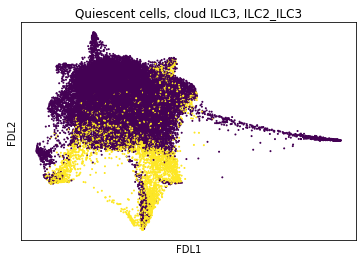

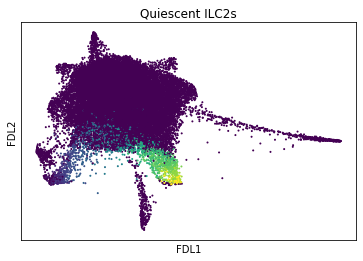

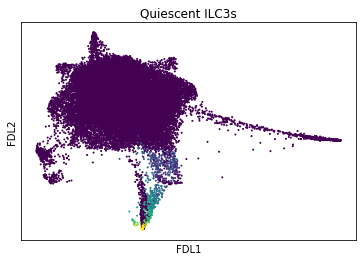

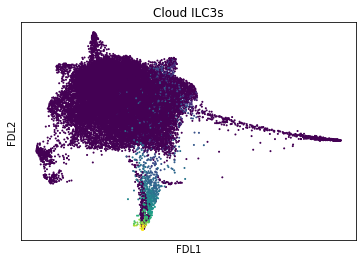

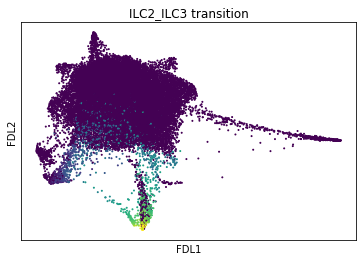

In [120]:
#There are some nan values in these arrays that we want to force to zero
val_ILC2_ILC3[np.isnan(val_ILC2_ILC3)] = 0
val_ILC3_Q[np.isnan(val_ILC3_Q)] = 0
val_ILC2_Q[np.isnan(val_ILC2_Q)] = 0
val_cloud_ILC3[np.isnan(val_cloud_ILC3)] = 0  

frame1 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = in_transition)
plt.title('Quiescent cells, cloud ILC3, ILC2_ILC3')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame2 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC2_Q)
plt.title('Quiescent ILC2s')
#plt.xlim(-30000,25000)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame3 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC3_Q)
plt.title('Quiescent ILC3s')
frame3.axes.get_xaxis().set_ticks([])
frame3.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame4 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_cloud_ILC3)
plt.title('Cloud ILC3s')
frame4.axes.get_xaxis().set_ticks([])
frame4.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame5 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC2_ILC3)
plt.title('ILC2_ILC3 transition')
frame5.axes.get_xaxis().set_ticks([])
frame5.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

### Creating normalized read matrix for only the cells of interest

In [123]:
#Numpy array with normalized reads for all cells
norm_reads = np.array(norm_reads)
print(norm_reads.shape)
PCA_coord = np.array(PCA_coord)
print(PCA_coord.shape)
Diff_coord = np.array(Diff_coord)
print(Diff_coord.shape)

#Number of genes to initialize new matrix
genes = Gene_list.shape[0]
reads = np.zeros((1,15806 ))

PCA_reads = np.zeros((1,50))
Diff_reads = np.zeros((1,15))

#Going through all of the cells, if the  associated index in index_cell is nonzero then 
#it was included in our group and we should pull the associated gene expression data
for i in range(0,cells):
    j = index_cells[i]
    if j != "0":
        next_cell = norm_reads[i,:]
        next_cell = np.reshape(next_cell, (1,15806 ))
        reads = np.append(reads, next_cell, axis = 0)
        
        next_PCA = PCA_coord[i,:]
        next_PCA = np.reshape(next_PCA, (1,50))
        PCA_reads = np.append(PCA_reads, next_PCA, axis = 0)
        
        next_Diff = Diff_coord[i,:]
        next_Diff = np.reshape(next_Diff, (1,15))
        Diff_reads = np.append(Diff_reads, next_Diff, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
reads = reads[1:, :]    
PCA_reads = PCA_reads[1:, :]
Diff_reads = Diff_reads[1:, :]

(26877, 15806)
(26877, 50)
(26877, 15)


# Save or read in matrix with cells of interest

In [11]:
np.savetxt("ILCs_reads.csv", reads, delimiter=',')
np.savetxt("ILCs_index.csv", index_val, delimiter=',', fmt="%s")
np.savetxt("index_cells.csv", index_cells, delimiter=',', fmt="%s")

In [12]:
ILCs_reads = pd.read_csv("ILCs_reads.csv", sep=",", header = None) #Normalized gene expression of cells of interest
ILCs_reads_values = np.array(ILCs_reads)

ILCs_index = pd.read_csv("ILCs_index.csv", sep=",", header = None)

### UMAP of selected cells

In [124]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(ILCs_reads_values)
embedding.shape

(3807, 2)

In [14]:
#np.savetxt("UMAP_all_ILC_norm.csv", embedding, delimiter=',')
#embedding = pd.read_csv("UMAP_all_ILC_norm.csv", sep=",", header = None)
#embedding = np.array(embedding)

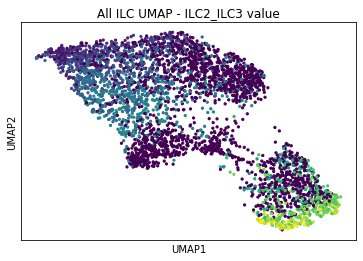

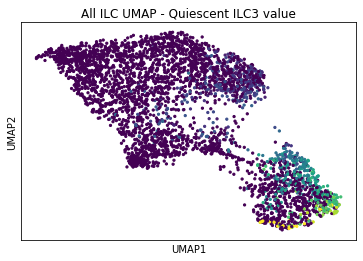

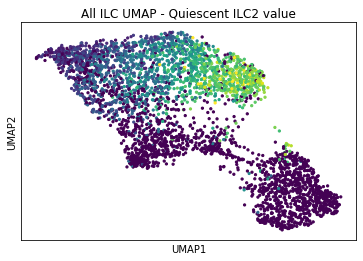

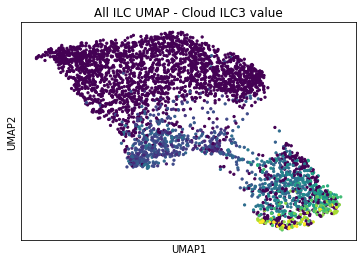

In [125]:
frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = val_ILC2_ILC3)
plt.title('All ILC UMAP - ILC2_ILC3 value')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame2 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = val_ILC3_Q)
plt.title('All ILC UMAP - Quiescent ILC3 value')
#plt.xlim(-30000,25000)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame3 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = val_ILC2_Q)
plt.title('All ILC UMAP - Quiescent ILC2 value')
#plt.xlim(-30000,25000)
frame3.axes.get_xaxis().set_ticks([])
frame3.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame4 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = val_cloud_ILC3)
plt.title('All ILC UMAP - Cloud ILC3 value')
#plt.xlim(-30000,25000)
frame4.axes.get_xaxis().set_ticks([])
frame4.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()


### To look at individual genes on this UMAP

In [126]:
#To look at expression of individual genes on the UMAP we pull the index from our Gene_list

G = "Il4"
Gene_list = np.array(Gene_list)

for i in range(0,genes):
    if Gene_list[i] == G:
        gene_index = i

print(str(G)+' index: '+str(gene_index))

Il4 index: 2018


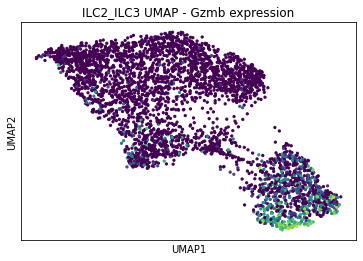

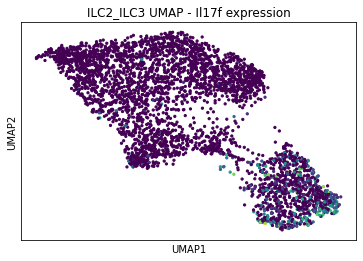

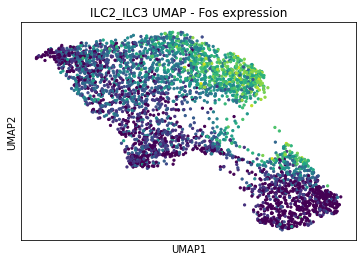

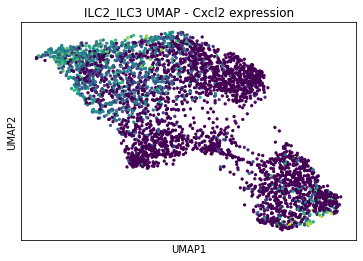

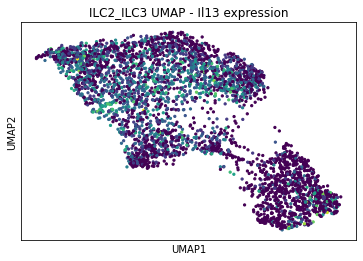

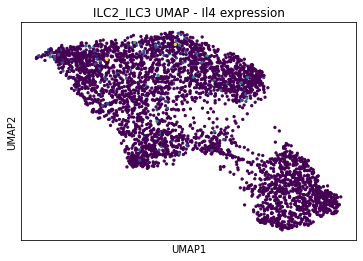

In [127]:
frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,1722])
plt.title('ILC2_ILC3 UMAP - Gzmb expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,8])
plt.title('ILC2_ILC3 UMAP - Il17f expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,2427])
plt.title('ILC2_ILC3 UMAP - Fos expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,881])
plt.title('ILC2_ILC3 UMAP - Cxcl2 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,2019])
plt.title('ILC2_ILC3 UMAP - Il13 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,2018])
plt.title('ILC2_ILC3 UMAP - Il4 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

## Preprocessing

In [128]:
center = np.argsort(val_ILC2_ILC3)[val_ILC2_ILC3.shape[0]//2]
print(center)

[0]


In [129]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection
from manifold_utils.iga import chakraborty_express, iga

ILCs_index = np.array(ILCs_index)

ILCs = ILCs_reads_values
N, d = ILCs.shape


In [130]:
dist_mat = np.zeros((N, N))
for j in range(0,N):
    for k in range(0,N):
        if j != k:
            dist_mat[j, k] = np.linalg.norm(ILCs[j, :] - ILCs[k, :])

In [ ]:
#print(dist_mat.shape)

#savetxt('dist_mat_allILC.csv', dist_mat, delimiter=',')

dist_mat = pd.read_csv('dist_mat_allILC.csv', sep=",", header = None)
dist_mat = np.array(dist_mat )

In [131]:
#PCA distance
N, d = PCA_reads.shape

dist_mat_PCA = np.zeros((N, N))
for j in range(0,N):
    for k in range(0,N):
        if j != k:
            dist_mat_PCA[j, k] = np.linalg.norm(PCA_reads[j, :] - PCA_reads[k, :])

#Diffusion distance
N, d = Diff_reads.shape

dist_mat_Diff = np.zeros((N, N))
for j in range(0,N):
    for k in range(0,N):
        if j != k:
            dist_mat_Diff[j, k] = np.linalg.norm(Diff_reads[j, :] - Diff_reads[k, :])
            
            


Applying preproccessing to matrix - ILC_gene_expression_values

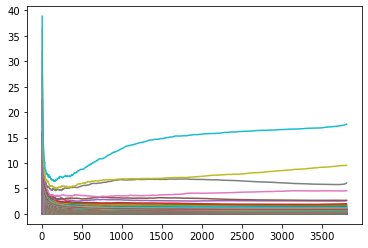

In [132]:
center = 2500
radii, numPoints_list, eigval_list, eigvec_list = eigen_calc_from_dist_mat(ILCs, dist_mat, center)

rmin = radii[0]
rmax = radii[-1]

eigen_plot(eigval_list, numPoints_list)

In [133]:
print('Min: '+repr((21 - rmin)/0.01))
print('Max: '+repr((22 - rmin)/0.01))

Min: 278.40038936645504
Max: 378.40038936645504


In [134]:
evec = eigvec_list[269][:,0:2]
print(evec.shape)

evec_list = []

for i in range(0,100):
    evec_list.append( eigvec_list[218+i][:,0:2])
    
print(type(evec_list))


(3000, 2)
<class 'list'>


In [135]:
IGA = iga(evec_list)

In [136]:
IGA.shape

(3000, 2)

In [137]:
center = 2500
center_val = 2500
proj = eps_projection(ILCs,IGA,ILCs[center, :])

p = np.array(proj)

#savetxt('eps_projection_allILC.csv', p, delimiter=',')

In [138]:
in_ball = np.zeros(val_ILC2_ILC3.shape)
p_in_ball = np.zeros((1,p.shape[1]))
val_ILC2_ILC3_in_ball = np.array([])
val_ILC3_Q_in_ball = np.array([])
val_ILC2_Q_in_ball = np.array([])
val_cloud_ILC3_in_ball = np.array([])

for i in range(0,3807):
    if dist_mat[i, center_val] < 23.5:
        in_ball[i] = 1
        p_in_ball = np.append(p_in_ball, np.reshape(p[i,:], (1,2)), axis = 0)
        
        val_ILC2_ILC3_in_ball = np.append(val_ILC2_ILC3_in_ball, val_ILC2_ILC3[i])
        val_ILC3_Q_in_ball = np.append(val_ILC3_Q_in_ball, val_ILC3_Q[i])
        val_ILC2_Q_in_ball = np.append(val_ILC2_Q_in_ball, val_ILC2_Q[i])
        val_cloud_ILC3_in_ball = np.append(val_cloud_ILC3_in_ball, val_cloud_ILC3[i])
    else:
        in_ball[i] = 0
        
p_in_ball = p_in_ball[1:, :]
print(p_in_ball.shape)

(2989, 2)


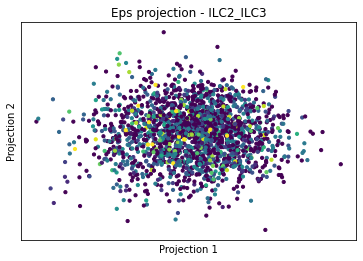

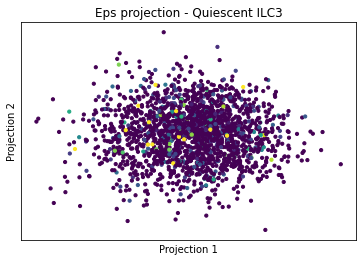

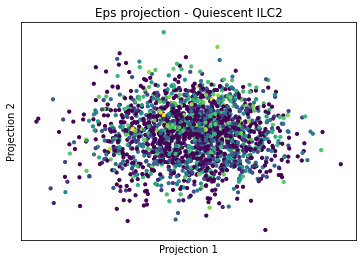

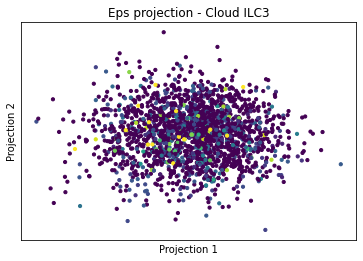

In [139]:
frame1 = plt.scatter(p_in_ball[:,0], p_in_ball[:,1], s = 10, c = val_ILC2_ILC3_in_ball)
plt.title('Eps projection - ILC2_ILC3')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projection 1')
plt.show()

frame2 = plt.scatter(p_in_ball[:,0], p_in_ball[:,1], s = 10, c = val_ILC3_Q_in_ball)
plt.title('Eps projection - Quiescent ILC3')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projection 1')
plt.show()

frame3 = plt.scatter(p_in_ball[:,0], p_in_ball[:,1], s = 10, c = val_ILC2_Q_in_ball)
plt.title('Eps projection - Quiescent ILC2')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
frame3.axes.get_xaxis().set_ticks([])
frame3.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projection 1')
plt.show()

frame4 = plt.scatter(p_in_ball[:,0], p_in_ball[:,1], s = 10, c = val_cloud_ILC3_in_ball)
plt.title('Eps projection - Cloud ILC3')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
frame4.axes.get_xaxis().set_ticks([])
frame4.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projection 1')
plt.show()

## Visualizing centers

In [140]:
#center_val = np.random.randint(0,3807)
center_val = 2500
print("Center: "+repr(center_val))

Center: 2500


In [141]:

center = np.ones(cells)
counter = 0



for i in range(0,cells):
    if in_transition[i] == 1:
        counter += 1
        if counter == center_val:
            print(i)
            break

ILC_Diff = np.zeros((1,2))
ILC_UMAP = np.zeros((1,2))

index = 0
for j in range(0,cells):
    if in_transition[j] == 1:

        ILC_Diff = np.append(ILC_Diff, np.reshape(Diff[j,:], (1,2)), axis = 0) 
        ILC_UMAP = np.append(ILC_UMAP, np.reshape(UMAP[j,:], (1,2)), axis = 0) 
        if dist_mat[index, center_val] < 20:
            center[j] = 4.0
            
        elif dist_mat[index, center_val] < 22.5:
            center[j] = 3.0
            
        elif dist_mat[index, center_val] < 25:
            center[j] = 2.0
        
        elif dist_mat[index, center_val] < 30:
            center[j] = 1.0
        index += 1

    else:
        center[j] = 0.0
        
ILC_Diff = ILC_Diff[1:, :]
ILC_UMAP = ILC_UMAP[1:, :]

19168


In [142]:
dist_mat[center_val,center_val]

0.0

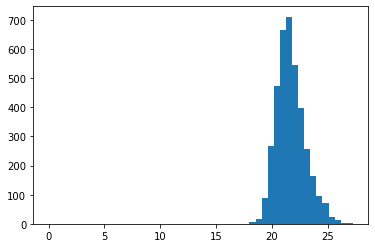

In [143]:
frame1 = plt.hist(dist_mat[0,:], bins = 50)

plt.show()

In [144]:
print(dist_mat[1, center_val]<21.5)

print(np.amax(dist_mat[:, center_val]))
print(np.amin(dist_mat[:, center_val]))

False
29.37186005383962
0.0


In [153]:
dist_mat

array([[ 0.        , 21.38955568, 20.52522228, ..., 24.05320217,
        19.98386801, 23.56990537],
       [21.38955568,  0.        , 19.31871996, ..., 22.32163376,
        22.11069022, 23.65337442],
       [20.52522228, 19.31871996,  0.        , ..., 24.39409442,
        20.60399236, 24.56520148],
       ...,
       [24.05320217, 22.32163376, 24.39409442, ...,  0.        ,
        23.9040483 , 19.27631356],
       [19.98386801, 22.11069022, 20.60399236, ..., 23.9040483 ,
         0.        , 24.06554088],
       [23.56990537, 23.65337442, 24.56520148, ..., 19.27631356,
        24.06554088,  0.        ]])

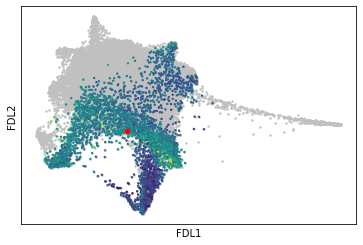

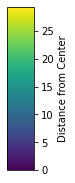

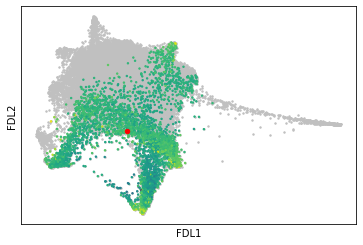

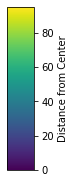

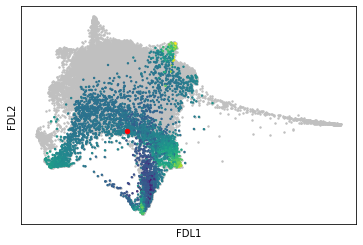

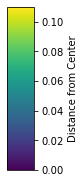

In [147]:
frame1 = plt.scatter(Diff[:,0], Diff[:,1], s=2, c = "silver")
frame1 = plt.scatter(ILC_Diff[:,0], ILC_Diff[:,1], s=2, c = dist_mat[:, center_val],vmin = 18)
frame1 = plt.scatter(Diff[i,0], Diff[i,1], s=20, c = "red")
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')

frame1, ax = plt.subplots(figsize=(1,3))
frame1.subplots_adjust(right=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.amin(dist_mat[:, center_val]), vmax=np.amax(dist_mat[:, center_val]))

frame1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Distance from Center')
plt.show()



frame1 = plt.scatter(Diff[:,0], Diff[:,1], s=2, c = "silver")
frame1 = plt.scatter(ILC_Diff[:,0], ILC_Diff[:,1], s=2, c = dist_mat_PCA[:, center_val])
frame1 = plt.scatter(Diff[i,0], Diff[i,1], s=20, c = "red")
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')

frame1, ax = plt.subplots(figsize=(1,3))
frame1.subplots_adjust(right=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.amin(dist_mat_PCA[:, center_val]), vmax=np.amax(dist_mat_PCA[:, center_val]))

frame1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Distance from Center')
plt.show()



frame1 = plt.scatter(Diff[:,0], Diff[:,1], s=2, c = "silver")
frame1 = plt.scatter(ILC_Diff[:,0], ILC_Diff[:,1], s=2, c = dist_mat_Diff[:, center_val])
frame1 = plt.scatter(Diff[i,0], Diff[i,1], s=20, c = "red")
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')

frame1, ax = plt.subplots(figsize=(1,3))
frame1.subplots_adjust(right=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.amin(dist_mat_Diff[:, center_val]), vmax=np.amax(dist_mat_Diff[:, center_val]))

frame1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Distance from Center')
plt.show()

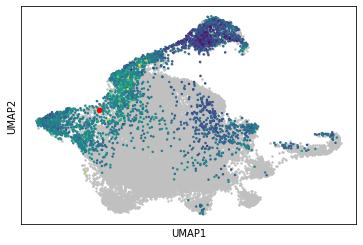

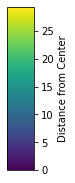

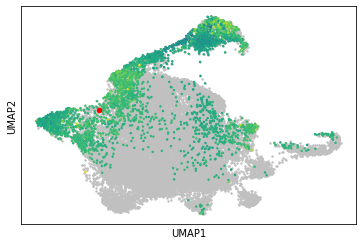

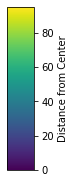

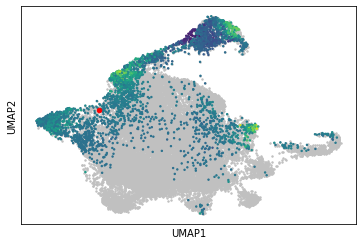

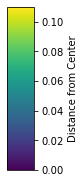

In [152]:
cmap = mpl.cm.viridis

frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=2, c = "silver")
frame1 = plt.scatter(ILC_UMAP[:,0], ILC_UMAP[:,1], s=2, c = dist_mat[:, center_val], vmin = 18, cmap = cmap)
frame1 = plt.scatter(UMAP[i,0], UMAP[i,1], s=20, c = "red")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
#frame1.colorbar(mpl.cm.ScalarMappable( norm=None, cmap=None), cax=ax, orientation='vertical', label='Distance from Center')

frame1, ax = plt.subplots(figsize=(1,3))
frame1.subplots_adjust(right=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.amin(dist_mat[:, center_val]), vmax=np.amax(dist_mat[:, center_val]))

frame1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Distance from Center')

#plt.xlim(-30000,25000)
plt.show()

frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=2, c = "silver")
frame1 = plt.scatter(ILC_UMAP[:,0], ILC_UMAP[:,1], s=2, c = dist_mat_PCA[:, center_val], cmap = cmap)
frame1 = plt.scatter(UMAP[i,0], UMAP[i,1], s=20, c = "red")
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

frame1, ax = plt.subplots(figsize=(1,3))
frame1.subplots_adjust(right=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.amin(dist_mat_PCA[:, center_val]), vmax=np.amax(dist_mat_PCA[:, center_val]))

frame1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Distance from Center')
plt.show()

frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=2, c = "silver")
frame1 = plt.scatter(ILC_UMAP[:,0], ILC_UMAP[:,1], s=2, c = dist_mat_Diff[:, center_val], cmap = cmap)
frame1 = plt.scatter(UMAP[i,0], UMAP[i,1], s=20, c = "red")
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

frame1, ax = plt.subplots(figsize=(1,3))
frame1.subplots_adjust(right=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.amin(dist_mat_Diff[:, center_val]), vmax=np.amax(dist_mat_Diff[:, center_val]))

frame1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Distance from Center')
plt.show()

## Trying other ways of visualizing distance

In [ ]:
M = dist_mat.shape[0]
distance = np.array([])

for i in range(0,M):
    if dist_mat[1000,i] == 0:
        U = np.append(dist_mat[1000,:i-1],dist_mat[1000,i+1:])
        distance = np.append(distance, 1/np.amin(U))
    else:
        distance = np.append(distance, 1/dist_mat[1000,i])
   
print(distance.shape)

In [ ]:
frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = distance)
frame1 = plt.scatter(embedding[1000,0], embedding[1000,1], s= 50, c = "red")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

In [ ]:
from sklearn import decomposition
from sklearn import datasets

pca = decomposition.PCA(n_components=10)
pca.fit(ILCs_reads_values)
X = pca.transform(ILCs_reads_values)

In [ ]:
frame1 = plt.scatter(X[:,0], X[:,1], s= 5, c = distance)
frame1 = plt.scatter(X[1000,0], X[1000,1], s= 50, c = "red")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [ ]:
reducer_ = umap.UMAP()
embedding_ = reducer_.fit_transform(X)
embedding_.shape

In [ ]:
frame1 = plt.scatter(embedding_[:,0], embedding_[:,1], s= 5, c = distance)
frame1 = plt.scatter(embedding_[1000,0], embedding_[1000,1], s= 50, c = "red")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

In [ ]:
print(np.amax(distance))

In [ ]:
print(np.amin(distance))

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(ILCs_reads_values)
X_embedded.shape

In [ ]:
frame1 = plt.scatter(X_embedded[:,0], X_embedded[:,1], s= 5, c = distance)
frame1 = plt.scatter(X_embedded[1000,0], X_embedded[1000,1], s= 50, c = "red")
plt.xlim(-30,30)
plt.ylim(-50,50)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('tSNE2')
plt.xlabel('tSNE1')
plt.show()